In [1]:
using MixedLayerModel
using FileIO
using DifferentialEquations
using Sundials
using Revise
using Plots

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger());

euler, dt=5 hours, stop=10 days


ODE   0%|                                               |  ETA: N/A
ODE  21%|█████████▊                                     |  ETA: 0:00:03
ODE  42%|███████████████████▋                           |  ETA: 0:00:02
ODE  62%|█████████████████████████████▍                 |  ETA: 0:00:01
ODE  83%|███████████████████████████████████████▏       |  ETA: 0:00:01


  3.323916 seconds (23.85 M allocations: 744.451 MiB, 2.90% gc time)
Success
[914.0844994859599, 312455.74758193997, 0.008769258507783524, 290.0]
[914.0844994859599, 312455.74758193997, 0.008769258507783524, 290.0]
[-8.660179815163548e-10, -2.6027569727870523e-12, 6.916097854286773e-11, 0.0]


ODE 100%|███████████████████████████████████████████████| Time: 0:00:03
┌ Warning: Skipped marker arg o-.
└ @ Plots /Users/claresinger/.julia/packages/Plots/HcxwM/src/args.jl:1178


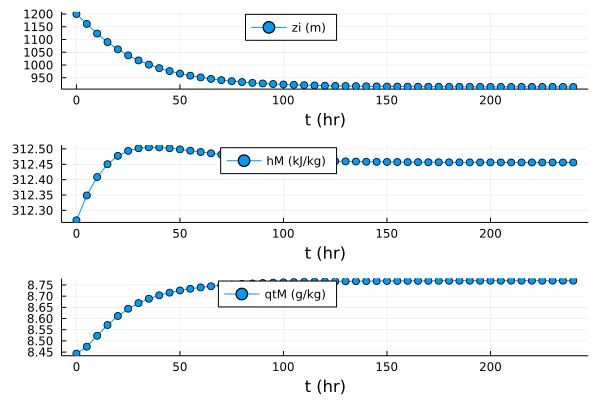

In [59]:
include("mlm_solve_funcs.jl")

# set-up basic 400 ppm simulation
par = basic_params();
par.etype = bflux();
path = "./output/bflux_timeevolve/";

# run to steady-state
u0, sol = run_mlm(par);

# get output
code = sol.retcode;
uf = sol.u[end];
du = zeros(4);
mlm(du, uf, par, 0.0);
zi,hM,qM,SST = uf;
zb = calc_LCL(zi,hM,qM);
println(code);
println(uf);
println(du ./ uf);

# save to file
output = Dict("code" => code, "p"=>par, "u0" => u0, "uf" => uf, "du/u" => du./uf, 
"we" => we(uf,par,par.etype), "zb" => zb, "zc" => zi-zb,
"RHsurf" => RH(0.0, hM, qM), "LHF" => calc_LHF(uf,par), "SHF" => calc_SHF(uf,par),
"ΔR" => calc_cloudtop_RAD(uf,par,par.rtype), "OHU" => calc_OHU(uf,par,par.stype));
save(path*"co2_400.jld2", output)

# plot
t = sol.t / 3600.0
zi = getindex.(sol.u,1)
hM = getindex.(sol.u,2) * 1e-3
qtM = getindex.(sol.u,3) * 1e3
plot(t, [zi, hM, qtM], marker="o-", xaxis="t (hr)", label=["zi (m)" "hM (kJ/kg)" "qtM (g/kg)"], legend=:top, layout=(3,1))

In [ ]:
include("mlm_solve_funcs.jl")

##########
# increase CO2 but fix SST
##########

# set co2
newCO2 = 600.0

par = basic_params();
par.etype = bflux();
path = "./output/bflux_timeevolve/";

# run to steady-state
u0, sol = run_mlm(par);
#println(sol);
plot(sol)

# get output
code = sol.retcode;
println(code);
uf = sol.u[end];
println(uf)
du = zeros(4);
mlm(du, uf, par, 0.0);
zi,hM,qM,SST = uf;
zb = calc_LCL(zi,hM,qM);
println(uf);
println(du ./ uf);

# save to file
output = Dict("code" => code, "p"=>par, "u0" => u0, "uf" => uf, "du/u" => du./uf, 
"we" => we(uf,par,par.etype), "zb" => zb, "zc" => zi-zb,
"RHsurf" => RH(0.0, hM, qM), "LHF" => calc_LHF(uf,par), "SHF" => calc_SHF(uf,par),
"ΔR" => calc_cloudtop_RAD(uf,par,par.rtype), "OHU" => calc_OHU(uf,par,par.stype));
save(path*"co2_400.jld2", output)

# plot
t = sol.t / 3600.0
zi = getindex.(sol.u,1)
hM = getindex.(sol.u,2) * 1e-3
qtM = getindex.(sol.u,3) * 1e3
plot(t, [zi, hM, qtM], marker="o-", xaxis="t (hr)", label=["zi (m)" "hM (kJ/kg)" "qtM (g/kg)"], legend=:top, layout=(3,1))

[914.0844994859599, 312455.74758193997, 0.008769258507783524, 290.0]
[-8.660179815163548e-10, 1.1129542784545414e-7, 6.916097854286773e-11, 0.0]
euler, dt=5 hours, stop=10 days


ODE   0%|                                               |  ETA: N/A
ODE  21%|█████████▊                                     |  ETA: 0:00:02
ODE  42%|███████████████████▋                           |  ETA: 0:00:02
ODE  62%|█████████████████████████████▍                 |  ETA: 0:00:01
ODE  83%|███████████████████████████████████████▏       |  ETA: 0:00:00


  2.546509 seconds (18.37 M allocations: 572.988 MiB, 3.22% gc time)
Success
[655.3001919562197, 315139.2355486446, 0.009650437917445793, 290.0]


ODE 100%|███████████████████████████████████████████████| Time: 0:00:02
┌ Warning: Skipped marker arg o-.
└ @ Plots /Users/claresinger/.julia/packages/Plots/HcxwM/src/args.jl:1178


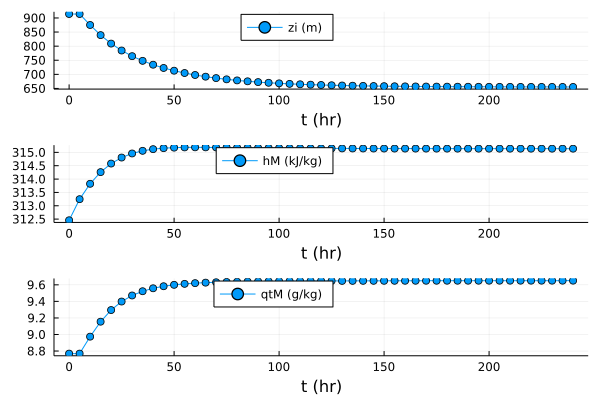

In [70]:
include("mlm_solve_funcs.jl")

# set co2
newCO2 = 1100.0

# load initial condition from file
path = "./output/bflux_timeevolve/";
output = load(path*"co2_400.jld2");
u0 = output["uf"];
println(u0);
mlm(du, u0, par, 0.0);
println(du ./ u0);

# increase CO2, let SST evolve and check cloud changes
par.CO2 = newCO2;
u0, sol = run_mlm_from_init(u0, par);

# get output
code = sol.retcode;
uf = sol.u[end];
du = zeros(4);
mlm(du, uf, par, 0.0);
zi,hM,qM,SST = uf;
zb = calc_LCL(zi,hM,qM);
println(code);
println(uf);
println(du ./ uf);

# save to file
output = Dict("code" => code, "p" => par, "u0" => u0, "uf" => uf, "du/u" => du./uf, 
"we" => we(uf,par,par.etype), "zb" => zb, "zc" => zi-zb,
"RHsurf" => RH(0.0, hM, qM), "LHF" => calc_LHF(uf,par), "SHF" => calc_SHF(uf,par),
"ΔR" => calc_cloudtop_RAD(uf,par,par.rtype), "OHU" => calc_OHU(uf,par,par.stype))
save(path*"co2_upstep_fixSST_"*string(Int(newCO2))*".jld2", output)

# plot
t = sol.t / 3600.0
zi = getindex.(sol.u,1)
hM = getindex.(sol.u,2) * 1e-3
qtM = getindex.(sol.u,3) * 1e3
plot(t, [zi, hM, qtM], marker="o-", xaxis="t (hr)", label=["zi (m)" "hM (kJ/kg)" "qtM (g/kg)"], legend=:top, layout=(3,1))

[914.0844994859599, 312455.74758193997, 0.008769258507783524, 290.0]
[-8.660179815163548e-10, 1.2656805058010438e-7, 6.916097854286773e-11, 0.0]
euler, dt=4.0 hours, stop=20.0 days


ODE   0%|                                               |  ETA: N/A
ODE   8%|███▉                                           |  ETA: 0:00:12
ODE  17%|███████▉                                       |  ETA: 0:00:10
ODE  25%|███████████▊                                   |  ETA: 0:00:08
ODE  33%|███████████████▋                               |  ETA: 0:00:07
ODE  42%|███████████████████▋                           |  ETA: 0:00:06
ODE  50%|███████████████████████▌                       |  ETA: 0:00:05
ODE  58%|███████████████████████████▍                   |  ETA: 0:00:04
ODE  67%|███████████████████████████████▍               |  ETA: 0:00:03
ODE  75%|███████████████████████████████████▎           |  ETA: 0:00:03
ODE  83%|███████████████████████████████████████▏       |  ETA: 0:00:02
ODE  92%|███████████████████████████████████████████▏   |  ETA: 0:00:01


 10.002762 seconds (71.87 M allocations: 2.189 GiB, 3.05% gc time)
Success
[1372.5168962947046, 324440.8323350598, 0.010445074828761862, 296.6442249721228]
[-4.6333746064096856e-9, -2.269144683254274e-10, -5.715452353782653e-10, -1.0594947985792042e-10]


ODE 100%|███████████████████████████████████████████████| Time: 0:00:10
ODE 100%|███████████████████████████████████████████████| Time: 0:00:10
┌ Warning: Skipped marker arg o-.
└ @ Plots /Users/claresinger/.julia/packages/Plots/HcxwM/src/args.jl:1178


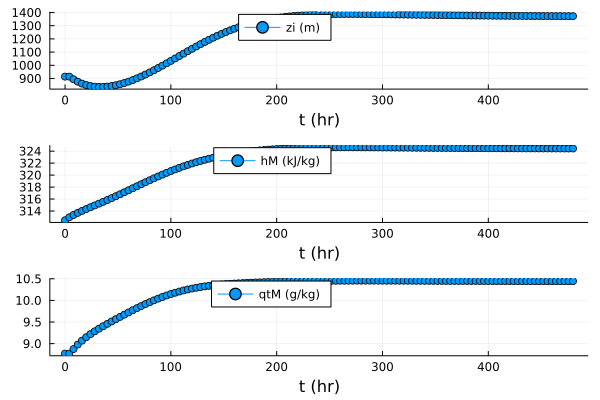

In [82]:
include("mlm_solve_funcs.jl")

# set co2
newCO2 = 900.0

# load initial condition from file
path = "./output/bflux_timeevolve/";
output = load(path*"co2_400.jld2");
u0 = output["uf"];
OHU = output["OHU"];
println(u0);
mlm(du, u0, par, 0.0);
println(du ./ u0);

# set OHU, let SST evolve and check cloud changes
par.CO2 = newCO2;
par.Hw = 1;
par.OHU = OHU;
par.stype = varSST();
u0, sol = run_mlm_from_init(u0, par);

# get output
code = sol.retcode;
uf = sol.u[end];
du = zeros(4);
mlm(du, uf, par, 0.0);
zi,hM,qM,SST = uf;
zb = calc_LCL(zi,hM,qM);
println(code);
println(uf);
println(du ./ uf);

# save to file
output = Dict("code" => code, "p" => par, "u0" => u0, "uf" => uf, "du/u" => du./uf, 
"we" => we(uf,par,par.etype), "zb" => zb, "zc" => zi-zb,
"RHsurf" => RH(0.0, hM, qM), "LHF" => calc_LHF(uf,par), "SHF" => calc_SHF(uf,par),
"ΔR" => calc_cloudtop_RAD(uf,par,par.rtype), "OHU" => calc_OHU(uf,par,par.stype))
save(path*"co2_upstep_"*string(Int(newCO2))*".jld2", output)

# plot
t = sol.t / 3600.0
zi = getindex.(sol.u,1)
hM = getindex.(sol.u,2) * 1e-3
qtM = getindex.(sol.u,3) * 1e3
plot(t, [zi, hM, qtM], marker="o-", xaxis="t (hr)", label=["zi (m)" "hM (kJ/kg)" "qtM (g/kg)"], legend=:top, layout=(3,1))